In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
#!{sys.executable} -m pip install tensorflow-gpu==2.4
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/vlian/anaconda3/envs/dune-1dcnn/lib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

'export' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from tqdm import trange

# Load data, select ADC

In [3]:
wireplane = "V"
sig_name = wireplane+"-signal"
cln_name = wireplane+"-clnsig"
np.random.seed(42)
nticks = 200
max_mels = 11000
min_edp = 50000
ADC_MIN = 3
ADC_MAX = 10
waveform_scaler = StandardScaler()

def extract_wave(data):
    string = 'tck_'
    waveforms = []
    #Here I extract a column in each iteration and append to list
    for i in range(nticks):
        waveforms.append(data[string+str(i)].astype(np.int16))
    #convert to numpy ndarray
    waveforms = np.array(waveforms).astype(np.int16)
    #since raws and columns are inverted we need to transpose it
    return np.transpose(waveforms)

def extract_peak(data):
    #extract index of peak
    idx = np.array([data['stp0'], data['adc0'], data['stp1'], data['adc1'], data['stp2'], data['adc2'], data['stp3'], data['adc3'], data['stp4'], data['adc4']])
    #same as before
    return np.transpose(idx)

def extract_peak_info(data):
    peaks_pos = [data['stp0'], data['stp1'], data['stp2'], data['stp3'], data['stp4']]
    adcs = [data['adc0'], data['adc1'], data['adc2'], data['adc3'], data['adc4']]
    return np.array(peaks_pos).T, np.array(adcs).T

def extract_nel_info(data):
    nels = [data['nel0'], data['nel1'], data['nel2'], data['nel3'], data['nel4']]
    return np.array(nels).T

def extract_edp_info(data):
    edp = [data['edp0'], data['edp1'], data['edp2'], data['edp3'], data['edp4']]
    return np.array(edp).T

def filter_signals(data, clean_data, filter_adc_max=True):
    #edp_mask = np.all(extract_edp_info(data)>min_edp, axis = 1)
    #nel_mask = np.all(extract_nel_info(data)<max_mels, axis = 1)
    #pd.DataFrame(np.all(extract_edp_info(data)>min_edp, axis = 1)).describe()
    #print(edp_mask)
    #print(nel_mask)
    #filter_mask = nel_mask #np.logical_and(edp_mask,nel_mask) 
    filtered_data = data#[filter_mask]
    cln_filtered_data = clean_data#[filter_mask]
    
    filtered_peak = extract_peak_info(filtered_data)[1]
    if filter_adc_max:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
        peak_mask &= np.any(filtered_peak<ADC_MAX, axis = 1)
    else:
        peak_mask = np.any(filtered_peak>ADC_MIN, axis = 1)
    
    filtered_data = filtered_data[peak_mask]
    cln_filtered_data = cln_filtered_data[peak_mask]
    
    return filtered_data, cln_filtered_data, filtered_peak

def get_std_waveforms(data):
    #Extract and scale waveform data (passthrough rn)
    raw_waveforms = extract_wave(data)
    #print(raw_waveforms) 
    #scaled_waveforms = waveform_scaler.fit_transform(raw_waveforms)
    return raw_waveforms

In [4]:
#Load Training Data
path = "../../dunesnb/1dcnn/train/train/nu_cc/"
path2 = "../../dunesnb/1dcnn/train/train/nu_es/"

filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and sig_name in f)]
clean_filenames1 = [path+f for f in listdir(path) if (isfile(join(path, f)) and cln_name in f)]
filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and sig_name in f)]
clean_filenames2 = [path2+f for f in listdir(path2) if (isfile(join(path2, f)) and cln_name in f)]

filenames =  filenames1+filenames2
clean_filenames = clean_filenames1+clean_filenames2

combined_data = np.concatenate([np.load(fname) for fname in filenames])
combined_clean_data = np.concatenate([np.load(fname) for fname in clean_filenames])

In [5]:
noise_path = "../../dunesnb/1dcnn/train/train/noise/"
noise_filenames = [f for f in listdir(noise_path) if (isfile(join(noise_path, f)) and wireplane in f)]
print(len(noise_filenames))

combined_noise = np.concatenate([np.load(noise_path+fname) for fname in noise_filenames])
print(len(combined_noise))

110
108600


# Train/Noise Data Preprocessing



In [6]:
from sklearn.utils import shuffle
print(combined_data.shape[0])
#Filter out tiny signals < ADC_MIN, but leave big signals to test on (incl > ADC_MAX)
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, False)
print(combined_data.shape[0])

#split train and test sets (~50k ea before filtering) 
combined_data, x_test_data, combined_clean_data, x_test_clean  = train_test_split(
    combined_data, combined_clean_data, test_size=0.5, shuffle=True
)
print(combined_data.shape[0])
#filter data and extract waveforms of filtered data
combined_data, combined_clean_data, peak = filter_signals(combined_data, combined_clean_data, True)
signal_waveforms = get_std_waveforms(combined_data)
print(combined_data.shape[0])
#extract waveforms of noise
noise_waveforms = get_std_waveforms(combined_noise)

#extract waveforms of test data
test_signal_waveforms = get_std_waveforms(x_test_data)
print(test_signal_waveforms.shape[0])


206425
114954
57477
54733
57477


In [7]:
print(test_signal_waveforms.shape, signal_waveforms.shape, noise_waveforms.shape)

(57477, 200) (54733, 200) (108600, 200)


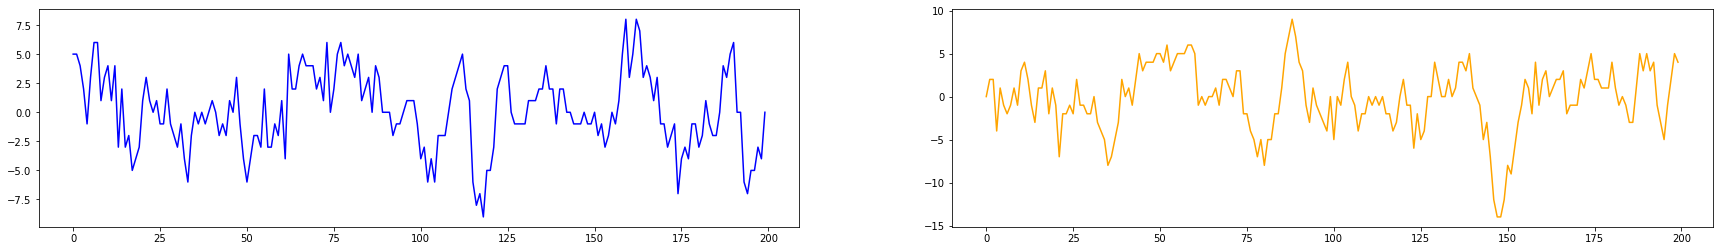

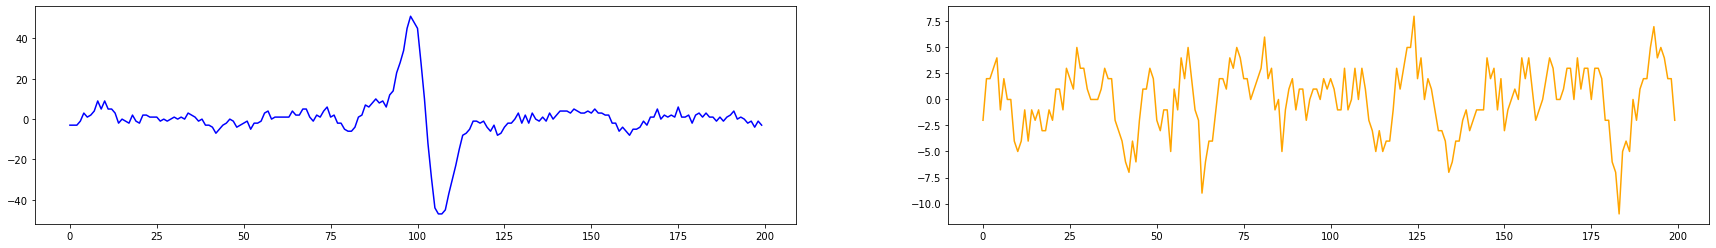

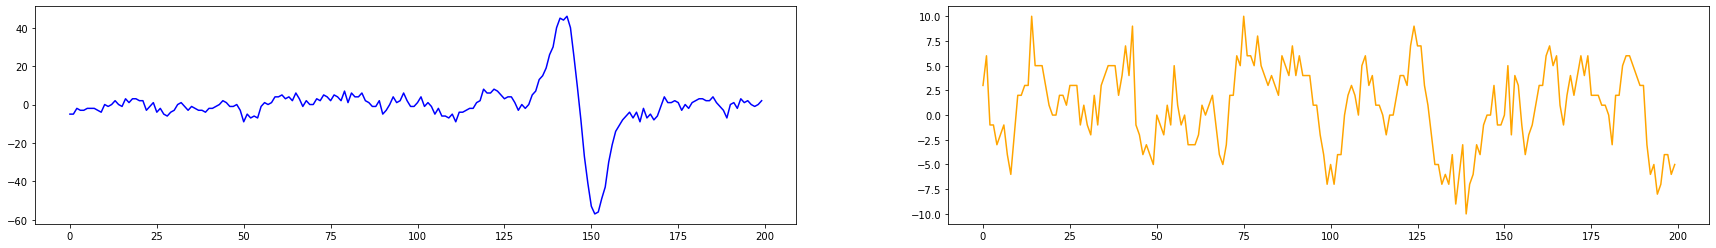

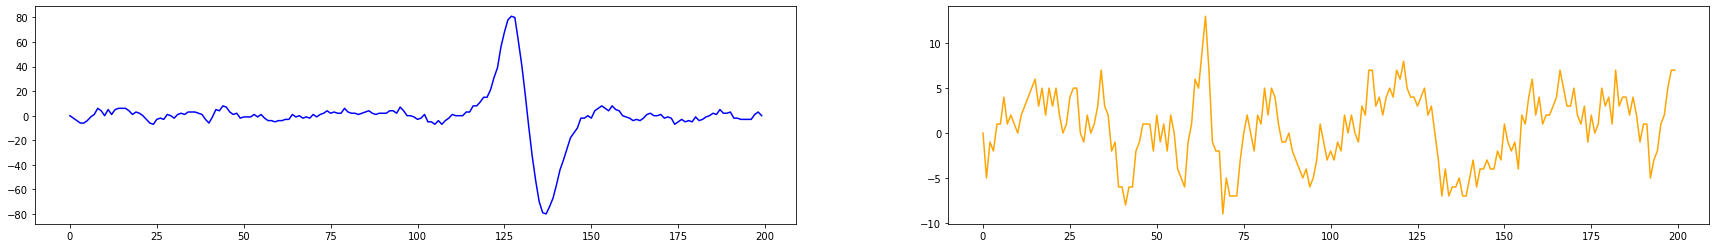

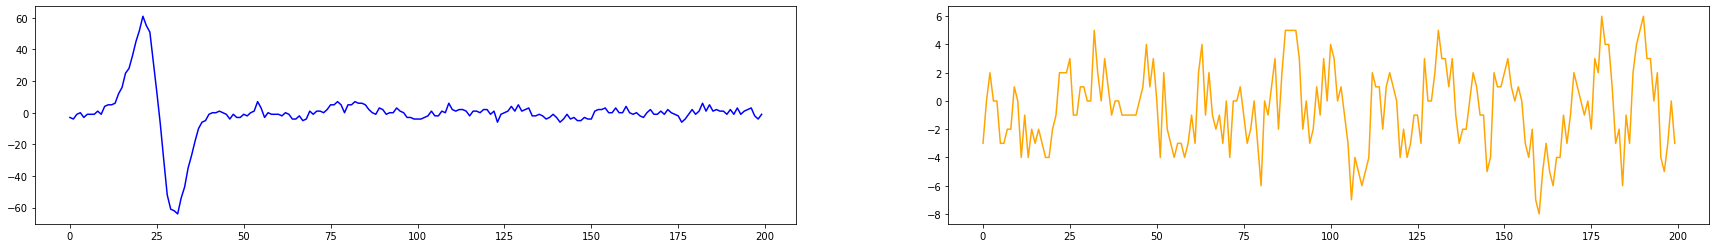

In [8]:
for idx in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 4))
    ax1.plot(signal_waveforms[idx], color='blue')

    ax2.plot(noise_waveforms[idx], color='orange')
    plt.show()

In [9]:
#generate y data (assuming all radiologicals contain signal, all noise does not)
y_noise_full = np.zeros(noise_waveforms.shape[0])
y_signal = np.ones(signal_waveforms.shape[0])
y_test_signal = np.ones(test_signal_waveforms.shape[0])

# split test and train noise datasets (50k)
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(
    noise_waveforms, y_noise_full, test_size=0.5, shuffle=True
)

#Shuffle signal waveforms to be safe
signal_waveforms, y_signal = shuffle(signal_waveforms,y_signal)

#Shuffle test waveformst to be safe
x_test, y_test = shuffle(test_signal_waveforms,y_test_signal)

In [10]:
print(x_noise_train.shape, signal_waveforms.shape, x_test.shape)

(54300, 200) (54733, 200) (57477, 200)


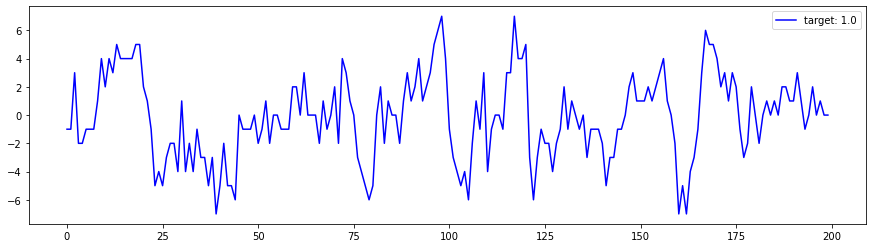

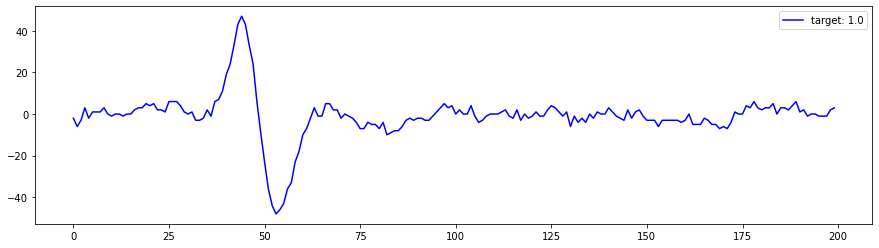

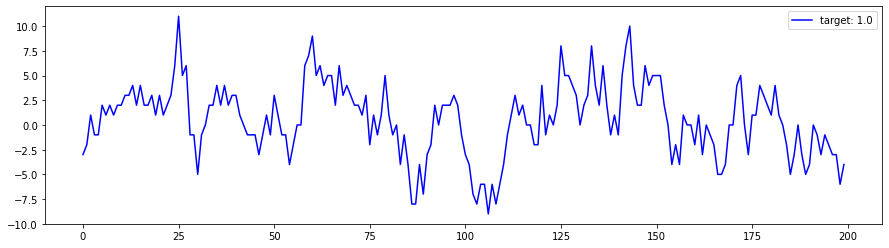

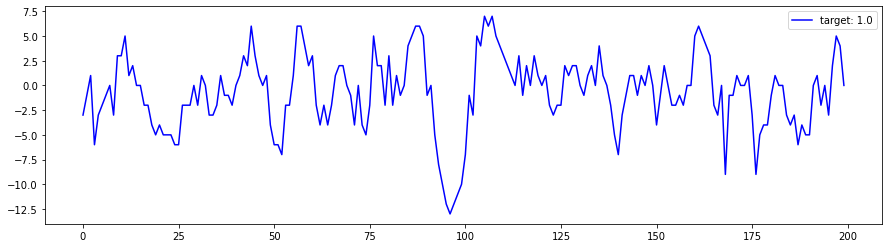

In [11]:
for idx in range(14205-4, 14205):
    fig, (ax1) = plt.subplots(figsize=(15, 4))
    ax1.plot(signal_waveforms[idx], color='blue', label= "target: " + str(y_signal[idx]))
    ax1.legend()
    plt.show()

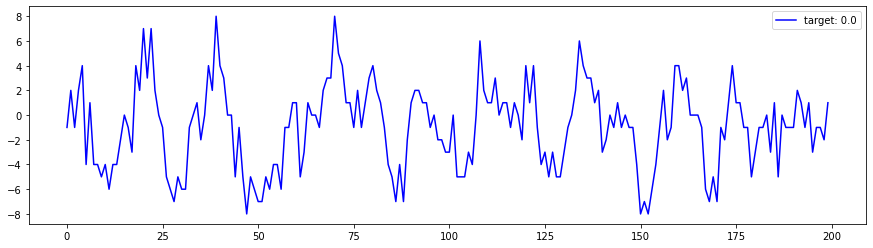

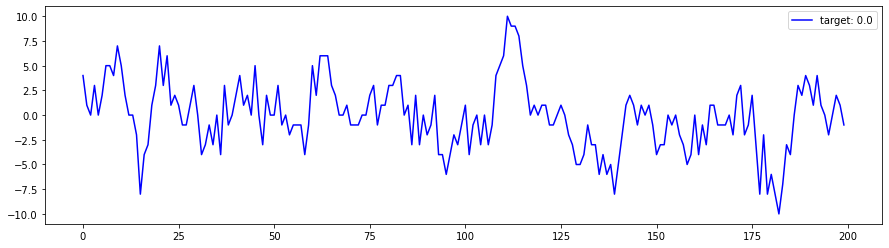

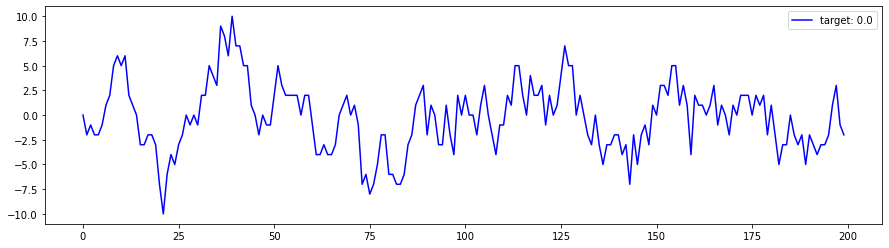

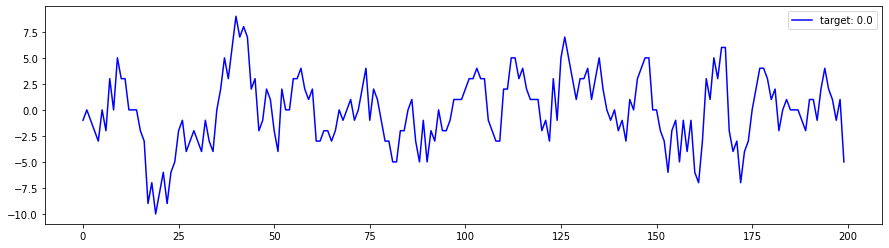

In [12]:
for idx in range(4):
    fig, (ax1) = plt.subplots(figsize=(15, 4))
    ax1.plot(x_noise_train[idx], color='blue', label= "target: " + str(y_noise_train[idx]))
    ax1.legend()
    plt.show()

In [13]:
#Select First n signal samples from (shuffled) set of signals where n = noise samples for balanced train set 
x_train = np.concatenate((signal_waveforms[:int(x_noise_train.shape[0])], x_noise_train))
y_train = np.concatenate((y_signal[:int(x_noise_train.shape[0])], y_noise_train))

x_test = np.concatenate((x_test[:int(x_noise_test.shape[0])], x_noise_test))
y_test = np.concatenate((y_test_signal[:int(x_noise_test.shape[0])], y_noise_test))


# extra train shuffle for good measure 
x_train, y_train = shuffle(x_train,y_train)
# extra test shuffle for good measure 
x_test, y_test = shuffle(x_test,y_test)

#split train and valid sets (40k train 10k valid) 
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=True
)

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape)

(86880, 200) (86880,) (108600, 200) (108600,) (21720, 200) (21720,)


In [15]:
mean = x_train.mean()
std = x_train.std()

In [16]:
x_train_scaled = (x_train-mean)/std
x_valid_scaled = (x_valid-mean)/std
x_test_scaled = (x_test-mean)/std
#cc_x_test_scaled = (cc_x_test-mean)/std 
#es_x_test_scaled = (es_x_test-mean)/std 
time_periods = 200

In [17]:
np.save("models/mean_"+wireplane+"_nu", mean)
np.save("models/scale_"+wireplane+"_nu", std)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization

# 1D-CNN LArTPC Waveform Recognition

In [19]:
time_periods = 200
def create_model():
  model = Sequential()  
  #first convolutional block
  model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation = "relu", input_shape=(time_periods,1)))
  model.add(MaxPooling1D(pool_size=2))

  #second convolutional block
  model.add(Conv1D(filters=32, kernel_size=5, strides=2, activation = "relu"))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.1))
  
  #forth convolutional block                                      
  model.add(Conv1D(filters=64, kernel_size=9, activation = "relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.2)) 
    
  model.add(Flatten())

  
 
  model.add(Dense(1, activation="sigmoid", name="wavrec_out"))
  return model

In [20]:
model = create_model()

#lr=0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 32)            2592      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 64)             1

In [21]:
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
#cc_x_test_scaled = cc_x_test_scaled.reshape(cc_x_test_scaled.shape[0], cc_x_test_scaled.shape[1], 1)
#es_x_test_scaled = es_x_test_scaled.reshape(es_x_test_scaled.shape[0], es_x_test_scaled.shape[1], 1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[1], 1)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

In [22]:
print(x_train_scaled.shape, x_valid_scaled.shape, x_test_scaled.shape)

(86880, 200, 1) (21720, 200, 1) (108600, 200, 1)


In [23]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [24]:
%%time
history = model.fit(x_train_scaled,                                                              
                    y_train,                                                            
                    batch_size=2048,                                              
                    epochs=100,      
                    
                   # epochs=30, 
                    #epochs = 6,
                    callbacks=[earlystop],
                     # callbacks=callbacks_list,                         
                    validation_data=(x_valid_scaled, y_valid),                                               
                    verbose=1)   

Epoch 1/100
43/43 [==============================] - 8s 18ms/step - loss: 0.4890 - accuracy: 0.7253 - val_loss: 0.3359 - val_accuracy: 0.8704
Epoch 2/100
43/43 [==============================] - 0s 8ms/step - loss: 0.3029 - accuracy: 0.8779 - val_loss: 0.2696 - val_accuracy: 0.8935
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2716 - accuracy: 0.8919 - val_loss: 0.2609 - val_accuracy: 0.8978
Epoch 4/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2643 - accuracy: 0.8950 - val_loss: 0.2535 - val_accuracy: 0.9019
Epoch 5/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2612 - accuracy: 0.8978 - val_loss: 0.2513 - val_accuracy: 0.9031
Epoch 6/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2566 - accuracy: 0.8995 - val_loss: 0.2489 - val_accuracy: 0.9039
Epoch 7/100
43/43 [==============================] - 0s 7ms/step - loss: 0.2549 - accuracy: 0.9008 - val_loss: 0.2480 - val_accuracy: 0.9035
Epoch 8/100


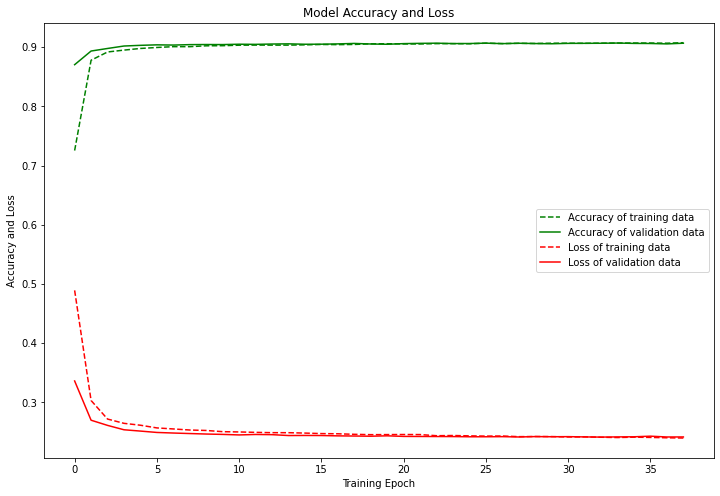

In [25]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data", antialiased=True)
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data", antialiased=True)
plt.plot(history.history['loss'], "r--", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "r", label="Loss of validation data", antialiased=True)
plt.title('Model Accuracy and Loss')                                            
plt.ylabel('Accuracy and Loss')                                                 
plt.xlabel('Training Epoch')                                                    
#plt.ylim(0)                                                                     
plt.legend()                                                                    
plt.show()     

In [26]:
#del x_train

import gc
gc.collect()

12651

In [27]:
model.save("models/model_" + wireplane + "plane_nu.h5")

In [28]:
model.evaluate(x_test_scaled, y_test, batch_size=4096)

27/27 [==============================] - 0s 12ms/step - loss: 0.2323 - accuracy: 0.9115


[0.2322790026664734, 0.9115101099014282]

In [29]:
x_train_ = x_train_scaled
y_train_ = y_train

x_valid_ = x_valid_scaled
y_valid_ = y_valid


# Train

In [30]:
%%time
%matplotlib inline
import seaborn as sns
infer = model.predict(x_train_, batch_size=1024)

85/85 [==============================] - 0s 2ms/step
Wall time: 585 ms


<AxesSubplot:>

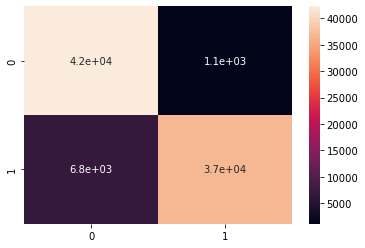

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train_, infer>0.5)
sns.heatmap(cm, annot=True)

<AxesSubplot:>

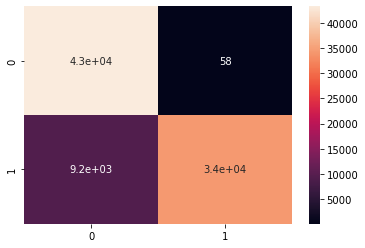

In [32]:
cm2 = confusion_matrix(y_train_, infer>0.9)
sns.heatmap(cm2, annot=True)

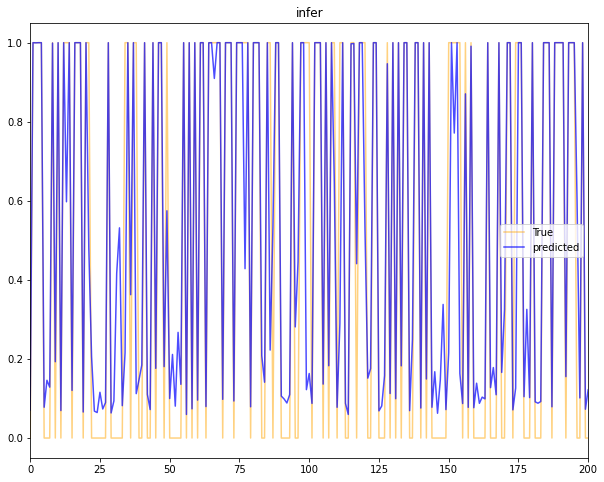

In [33]:
start_for_plot = 0
fig = plt.figure(figsize=(10, 8))
plt.plot(y_train,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_train_, infer)
auc_keras = auc(fpr_keras, tpr_keras)

In [35]:
print(auc_keras)

0.9498725754042933


In [36]:
np.save("results/false_positive_" + wireplane + "_train", fpr_keras)
np.save("results/true_positive_" + wireplane + "_train", tpr_keras)
np.save("results/thresholds_" + wireplane + "_train", thresholds_keras)

# Valid

In [37]:
%%time
infer = model.predict(x_valid_, batch_size=4096)

6/6 [==============================] - 0s 49ms/step
Wall time: 319 ms


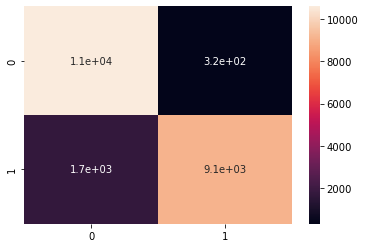

In [38]:
cmv = confusion_matrix(y_valid_, infer>0.5)
sns.heatmap(cmv, annot=True)
plt.show()

<AxesSubplot:>

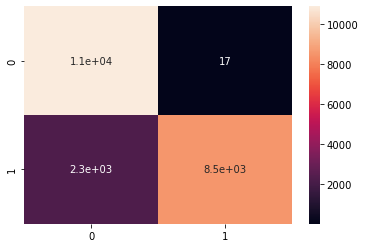

In [39]:
cmv2 = confusion_matrix(y_valid_, infer>0.9)
sns.heatmap(cmv2, annot=True)

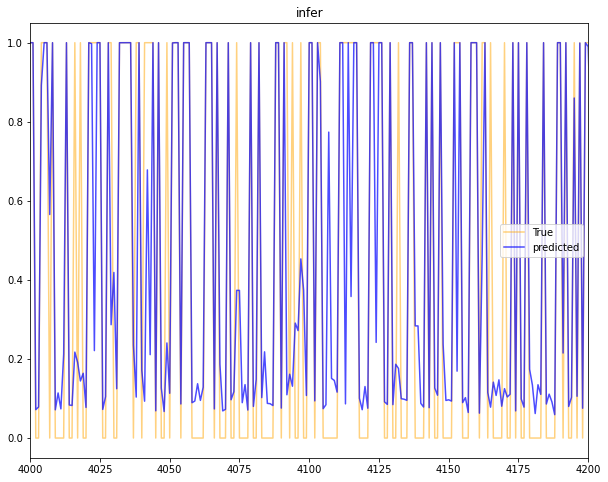

In [40]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(y_valid_,color='orange',alpha=0.5, label='True')
plt.plot(infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

In [41]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_valid_, infer)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.945813402592975


In [42]:
np.save("results/false_positive_" + wireplane + "_valid", fpr_keras)
np.save("results/true_positive_" + wireplane + "_valid", tpr_keras)
np.save("results/thresholds_" + wireplane + "_valid", thresholds_keras)

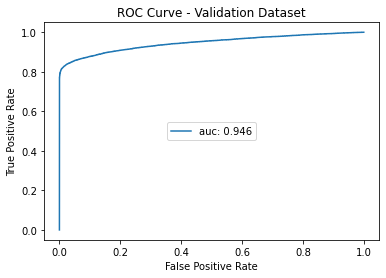

In [43]:
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc_keras,3)))
plt.title("ROC Curve - Validation Dataset")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

# test

In [44]:
#%%time
all_infer = model.predict(x_test_scaled, batch_size=4096)
all_y_test = y_test


27/27 [==============================] - 0s 5ms/step


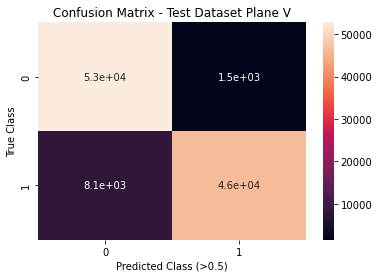

In [45]:
all1 = confusion_matrix(all_y_test, all_infer>0.5)
sns.heatmap(all1, annot=True)
plt.title("Confusion Matrix - Test Dataset Plane " + wireplane)
plt.xlabel("Predicted Class (>0.5)")
plt.ylabel("True Class")
plt.show()

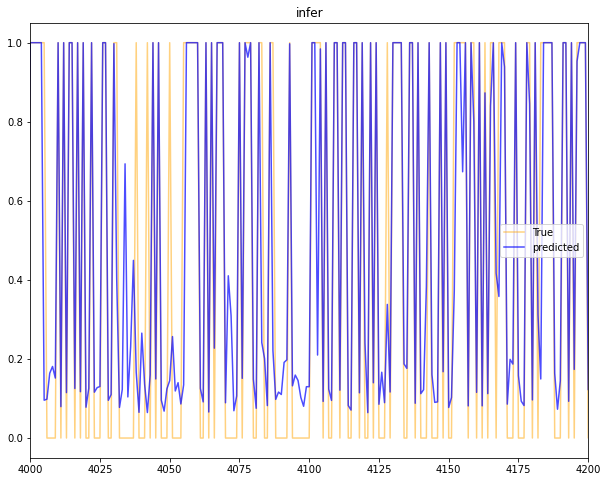

In [46]:
start_for_plot = 4000
fig = plt.figure(figsize=(10, 8))
plt.plot(all_y_test,color='orange',alpha=0.5, label='True')
plt.plot(all_infer,color='blue',alpha=0.7, label='predicted')
plt.xlim(start_for_plot, start_for_plot + 200)
plt.title("infer")
plt.legend()
plt.show()

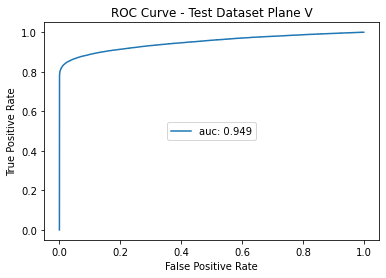

In [47]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane )
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')
plt.show()

In [48]:
%%time
#cc_infer_signal = model.predict(cc_x_test_scaled[cc_y_test==1], batch_size=4096)
#cc_infer_noise = model.predict(cc_x_test_scaled[cc_y_test==0], batch_size=4096)
#es_infer_signal = model.predict(es_x_test_scaled[es_y_test==1], batch_size=4096)
#es_infer_noise = model.predict(es_x_test_scaled[es_y_test==0], batch_size=4096)
all_infer_signal = model.predict(x_test_scaled[y_test==1], batch_size=4096)
all_infer_noise = model.predict(x_test_scaled[y_test==0], batch_size=4096)

14/14 [==============================] - 0s 2ms/step
Wall time: 505 ms


(array([3.0000e+00, 2.4055e+04, 1.5750e+04, 5.6820e+03, 2.8570e+03,
        1.6450e+03, 1.0820e+03, 7.2400e+02, 5.6100e+02, 4.2200e+02,
        3.5000e+02, 2.4000e+02, 2.2500e+02, 1.6700e+02, 1.2900e+02,
        1.2000e+02, 9.9000e+01, 9.6000e+01, 5.6000e+01, 3.7000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

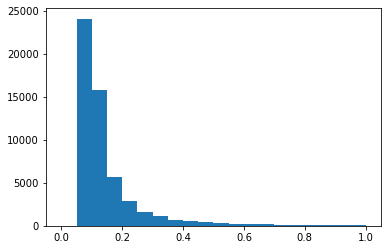

In [49]:
plt.hist(all_infer_noise, range = (0,1), bins=20)

(array([    0.,  1844.,  2135.,  1125.,   810.,   593.,   474.,   404.,
          392.,   314.,   326.,   313.,   315.,   299.,   310.,   327.,
          375.,   445.,   749., 42750.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

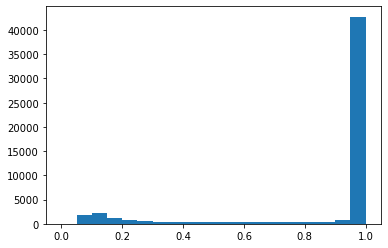

In [50]:
plt.hist(all_infer_signal, range = (0,1), bins=20)